In [1]:
# this notebook is a walkthrough on how to build collective variables using Supervised machine learning algorithms


# The general idea is to use the algorithm's decision function or the distance to an its decision boundary as the collective variable 


### The method is super generic, and only requires sampling in the start and end state to be able to build a classifier algorithm which we can then use to sample transitions between the state

In [1]:
# some imports 
import msmexplorer as msme
import numpy as np
%pylab inline
import seaborn as sns 
sns.set_style("whitegrid")
sns.set_context("poster",1.3)
from msmbuilder.utils import load

/Users/muneeb/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/muneeb/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


## These are the 4ns alanine training features

In [2]:
plot_feat = load("./train_data/raw_features.pkl")
train_feat = load("./train_data/features.pkl")

In [3]:
df = load("./train_data/feature_descriptor.pkl")

In [4]:
# The pandas data frame tells us what the features are that we are using
df

,atominds,featuregroup,featurizer,otherinfo,resids,resnames,resseqs
0,"[4, 6, 8, 14]",phi,Dihedral,sin,"[0, 1]","[ALA, ACE]","[1, 2]"
1,"[4, 6, 8, 14]",phi,Dihedral,cos,"[0, 1]","[ALA, ACE]","[1, 2]"
2,"[6, 8, 14, 16]",psi,Dihedral,sin,"[1, 2]","[ALA, NME]","[2, 3]"
3,"[6, 8, 14, 16]",psi,Dihedral,cos,"[1, 2]","[ALA, NME]","[2, 3]"


# we can either train a new model or use the one that is provided

In [4]:
from sklearn.svm import LinearSVC,SVC
import os

In [5]:
if not os.path.isfile("./svm_model_2.pkl"):
    clf = svc = LinearSVC(penalty="l1",C=1,dual=False)
    train =True 
else:
    clf = load("./svm_model_2.pkl")
    train =False

In [6]:
print(clf)

LinearSVC(C=1, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)


In [7]:
X=np.vstack(plot_feat)
train_X=np.vstack(train_feat)

y=np.concatenate([np.zeros(len(plot_feat[0])),
            np.ones(len(plot_feat[0]))])

if train:
    clf.fit(train_X,y)

In [8]:
train_X.sum(axis=1)[300:].std()

0.6109848

In [9]:
nx =ny=50
lim_x = lim_y = np.linspace(-pi,pi,nx)
xv, yv = np.meshgrid(lim_x, lim_y, sparse=False, indexing='ij')
res = []
for i in range(nx):
    for j in range(ny):
        X_val = np.array([np.sin(xv[i,j]),np.cos(xv[i,j]), np.sin(yv[i,j]), np.cos(yv[i,j])]).reshape(1,-1)
        res.extend(clf.predict(X_val))
#contourf(lim_x,lim_y,np.array(res).reshape(10,10),cmap='coolwarm')


/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


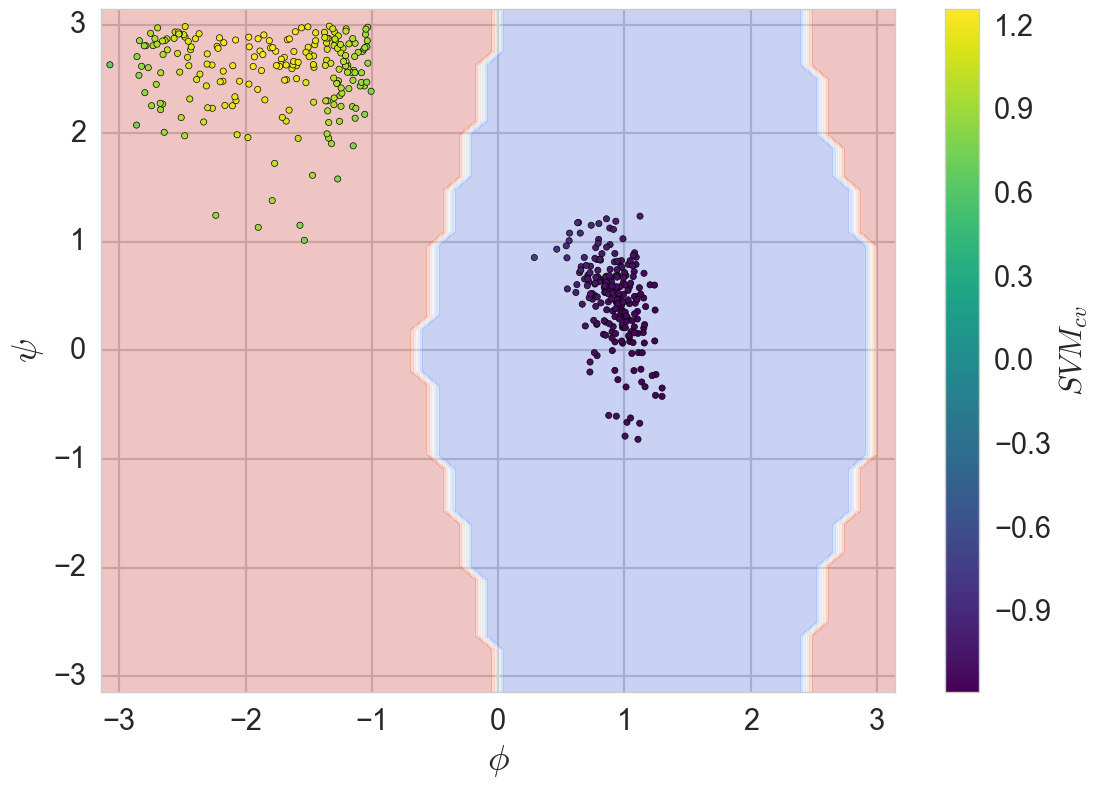

In [10]:
contourf(lim_x,lim_y,np.array(res).reshape(nx,ny).T,cmap="coolwarm",alpha=0.3)
p=scatter(np.vstack(plot_feat)[:,0],np.vstack(plot_feat)[:,1],
       c=clf.decision_function(train_X)/np.linalg.norm(clf.coef_),cmap='viridis')
xlim([-pi,pi])
ylim([-pi,pi])
cb=colorbar(p)
cb.set_label(r'$SVM_{cv}$')
ylabel(r'$\psi$',size=26)
xlabel(r'$\phi$',size=26)

In [21]:
df

,atominds,featuregroup,featurizer,otherinfo,resids,resnames,resseqs
0,"[4, 6, 8, 14]",phi,Dihedral,sin,"[0, 1]","[ALA, ACE]","[1, 2]"
1,"[4, 6, 8, 14]",phi,Dihedral,cos,"[0, 1]","[ALA, ACE]","[1, 2]"
2,"[6, 8, 14, 16]",psi,Dihedral,sin,"[1, 2]","[ALA, NME]","[2, 3]"
3,"[6, 8, 14, 16]",psi,Dihedral,cos,"[1, 2]","[ALA, NME]","[2, 3]"


In [173]:
if train:
    from msmbuilder.utils import dump
    dump(clf,"./svm_model_2.pkl")

In [176]:
b=clf.decision_function(train_X)/np.linalg.norm(clf.coef_)
np.std(b[300:])

0.13278091144412751

# Lets take a look at the feature coefficients as infered by the model

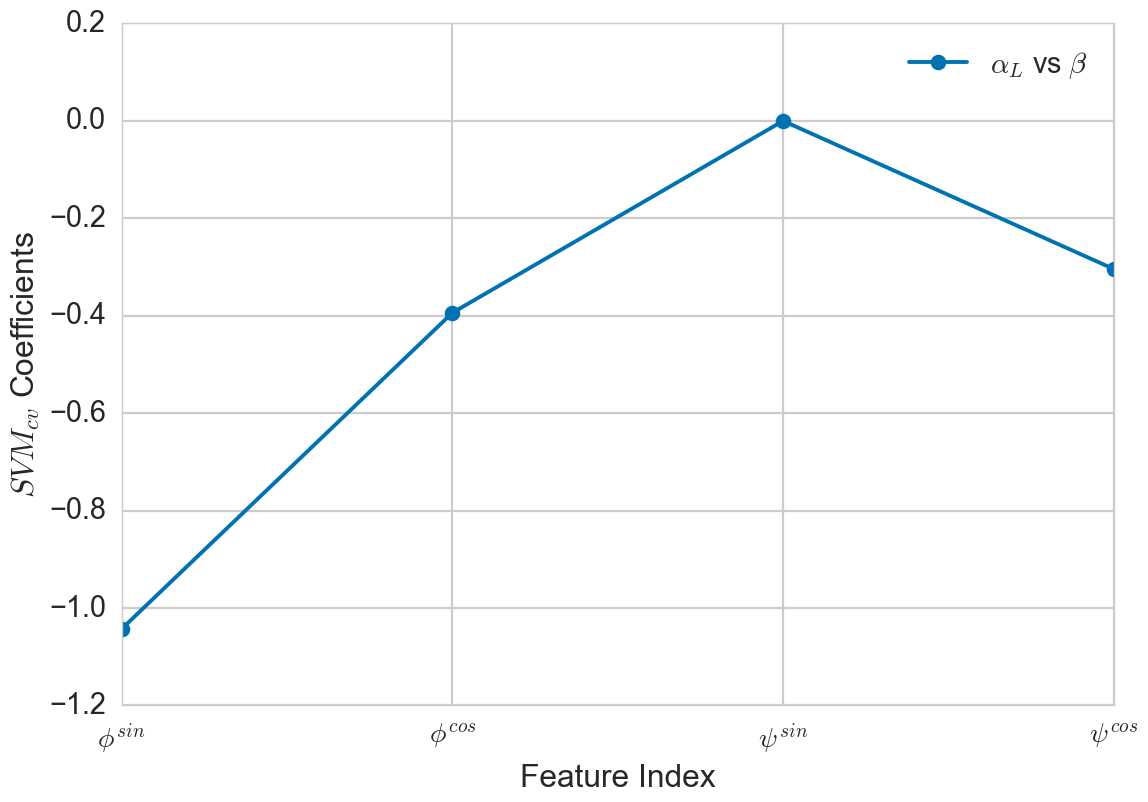

In [20]:
plot([0,1,2,3],clf.coef_[0],color=sns.color_palette("colorblind")[0],marker='o',label=r'$\alpha_L$ vs $\beta$')
xticks([0,1,2,3],[r'$\phi^{sin}$',r'$\phi^{cos}$',r'$\psi^{sin}$',r'$\psi^{cos}$'],size=20)
xlabel("Feature Index")
ylabel(r'$SVM_{cv}$ Coefficients')
legend()


# To sample the SVM's decision boundary repeatedly we need Plumed, OpenMM and the tica_metadynamics from github

In [156]:
from sklearn.utils.validation import check_is_fitted

In [157]:
# These imports are designed to interface between msmbuilder and Plumed
from tica_metadynamics.pyplumed import render_df
from tica_metadynamics.pyplumed import render_meta 
from jinja2 import Template

In [158]:
plumed_matheval_template = Template("MATHEVAL ARG={{arg}} FUNC={{func}} LABEL={{label}} PERIODIC={{periodic}} ")

plumed_combine_template = Template("COMBINE LABEL={{label}} ARG={{arg}} COEFFICIENTS={{coefficients}} "+\
                                    "PERIODIC={{periodic}} ")

# The function below will teach Plumed how to compute a distance to an SVM model's decision boundary.

### This is not necessary for most classifiers that ouput probabilities since we can directly use the probabilities as the collective variable in that instance. However, the output of SVM's is an indicator function defined using the signed distance to the decision boundary so we use that instead

In [177]:
def render_svm(clf=None, input_prefix="f0", output_prefix="l"):
    if clf is None or check_is_fitted(clf,attributes=["coef_","intercept_"]):
        raise ValueError("Need a fitted Sklearn SVM object")
    else:
        n_args = clf.coef_.shape[1]
        output = []
        arg_list=",".join(["%s_%d"%(input_prefix,i) for i in range(n_args)])
        coeff = ",".join([str(i) for i in clf.coef_[0]])
        w_norm = np.linalg.norm(clf.coef_)
        
        output.append(plumed_combine_template.render(label="%s_0"%output_prefix,
                                      arg=arg_list,
                                      coefficients=coeff,
                                      periodic="NO")+"\n")
        
        func="(x+%s)/%s"%(str(clf.intercept_[0]),str(w_norm))
        
        output.append(plumed_matheval_template.render(label="%s_1"%output_prefix,
                                      arg="l_0",
                                      func=func,
                                      periodic="NO")+"\n")        
        
    return ''.join(output)
        
        

In [180]:
total_out=[]
total_out.extend("RESTART\n")
total_out.extend(render_df(df))
total_out.extend(render_svm(clf))
total_out.extend(render_meta.render_metad_code("l_1",biasfactor=8,sigma=0.1))
total_out.extend(render_meta.render_metad_bias_print("l_1,metad.bias"))

In [181]:
print("".join(total_out))

RESTART
TORSION ATOMS=5,7,9,15 LABEL=phi_0_1 

TORSION ATOMS=7,9,15,17 LABEL=psi_1_2 

MATHEVAL ARG=phi_0_1 FUNC=sin(x) LABEL=f0_0 PERIODIC=NO 

MATHEVAL ARG=phi_0_1 FUNC=cos(x) LABEL=f0_1 PERIODIC=NO 

MATHEVAL ARG=psi_1_2 FUNC=sin(x) LABEL=f0_2 PERIODIC=NO 

MATHEVAL ARG=psi_1_2 FUNC=cos(x) LABEL=f0_3 PERIODIC=NO 

COMBINE LABEL=l_0 ARG=f0_0,f0_1,f0_2,f0_3 COEFFICIENTS=-1.04257231962,-0.393830044635,0.0,-0.304068047454 PERIODIC=NO 
MATHEVAL ARG=l_0 FUNC=(x+0.0516145681056)/1.155212761 LABEL=l_1 PERIODIC=NO 
METAD ARG=l_1 SIGMA=0.1 HEIGHT=1.0 FILE=HILLS TEMP=300 PACE=1000 LABEL=metad BIASFACTOR=8
PRINT ARG=l_1,metad.bias STRIDE=1000 FILE=BIAS 


In [36]:
# Run the metadynamics on a GPU

In [12]:
import mdtraj as md
from msmbuilder.featurizer import DihedralFeaturizer

In [182]:
test_traj = md.load("./svm_meta_traj_lowc/reweight//trajectory.dcd",top="./0.pdb")
feat = load("./train_data//featurizer.pkl")
bias = np.loadtxt("./svm_meta_traj_lowc/reweight//BIAS")

In [183]:
test_traj

<mdtraj.Trajectory with 4500 frames, 22 atoms, 3 residues, and unitcells at 0x1289e4eb8>

In [184]:
test_feat = feat.transform([test_traj])[0]
plot_test_feat = DihedralFeaturizer(sincos=False).transform([test_traj])[0]

In [185]:
clf_out =clf.decision_function(test_feat)/np.linalg.norm(clf.coef_)

In [186]:
clf

LinearSVC(C=1, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)

# Making sure that Sklearn and Plumed are computing the same value

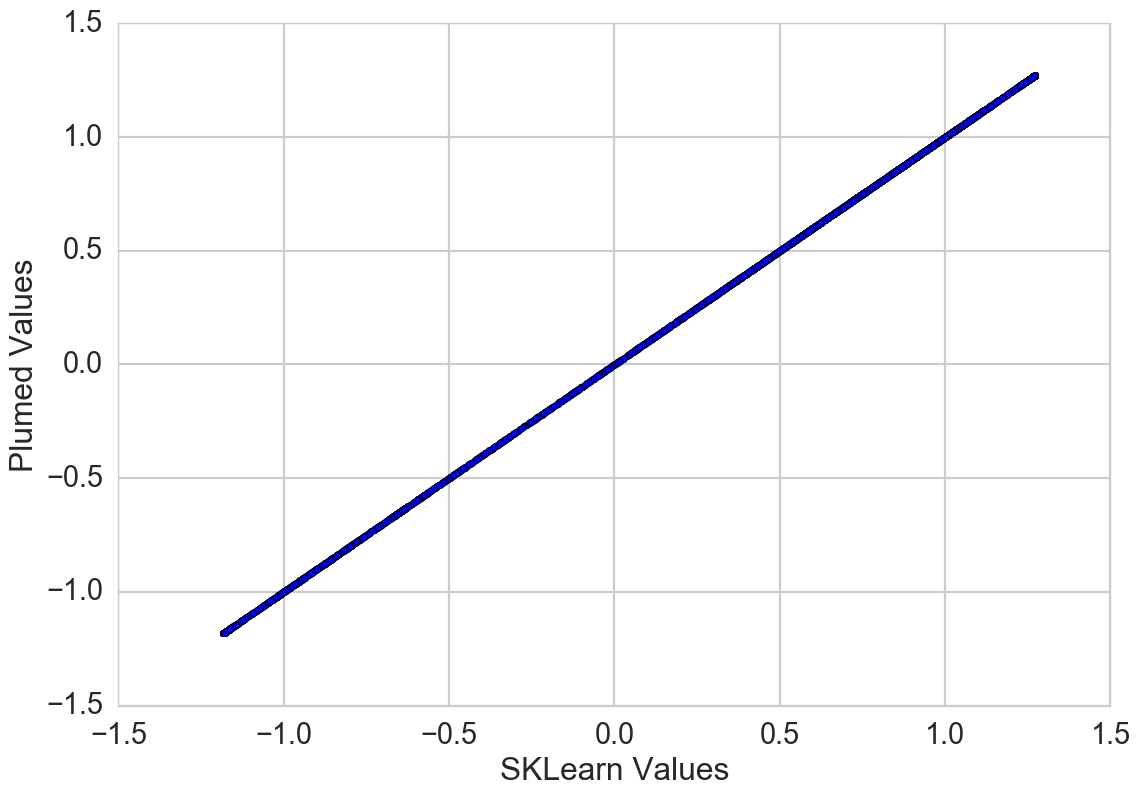

In [187]:
scatter(clf_out,bias[:,1])
xlabel("SKLearn Values")
ylabel("Plumed Values")

In [188]:
clf

LinearSVC(C=1, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)

# We can analyze this in terms of plotting the trajectories

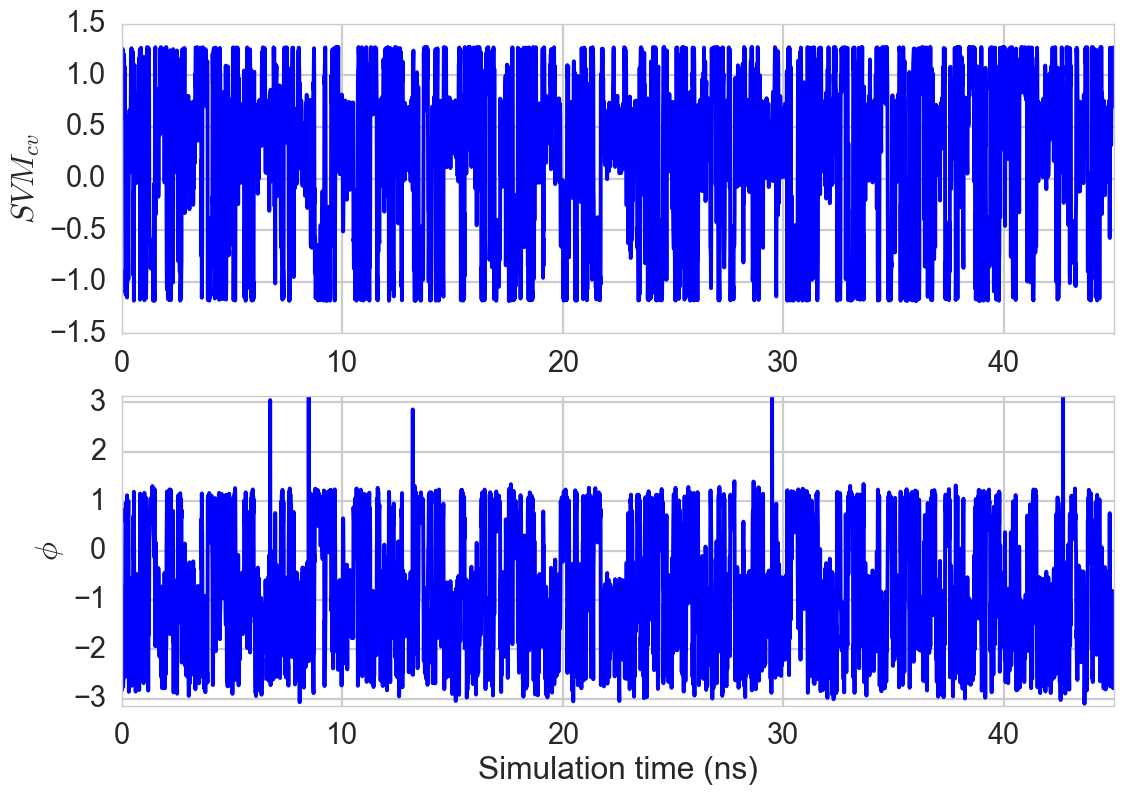

In [189]:
subplot(2,1,1)
plot(bias[:,1])
xticks([0,1000,2000,3000,4000],[0,10,20,30,40])
ylabel(r'$SVM_{cv}$')

subplot(2,1,2)
plot(plot_test_feat[:,0])
xticks([0,1000,2000,3000,4000],[0,10,20,30,40])
xlabel("Simulation time (ns)")
ylim([-pi,pi])
ylabel(r'$\phi$')

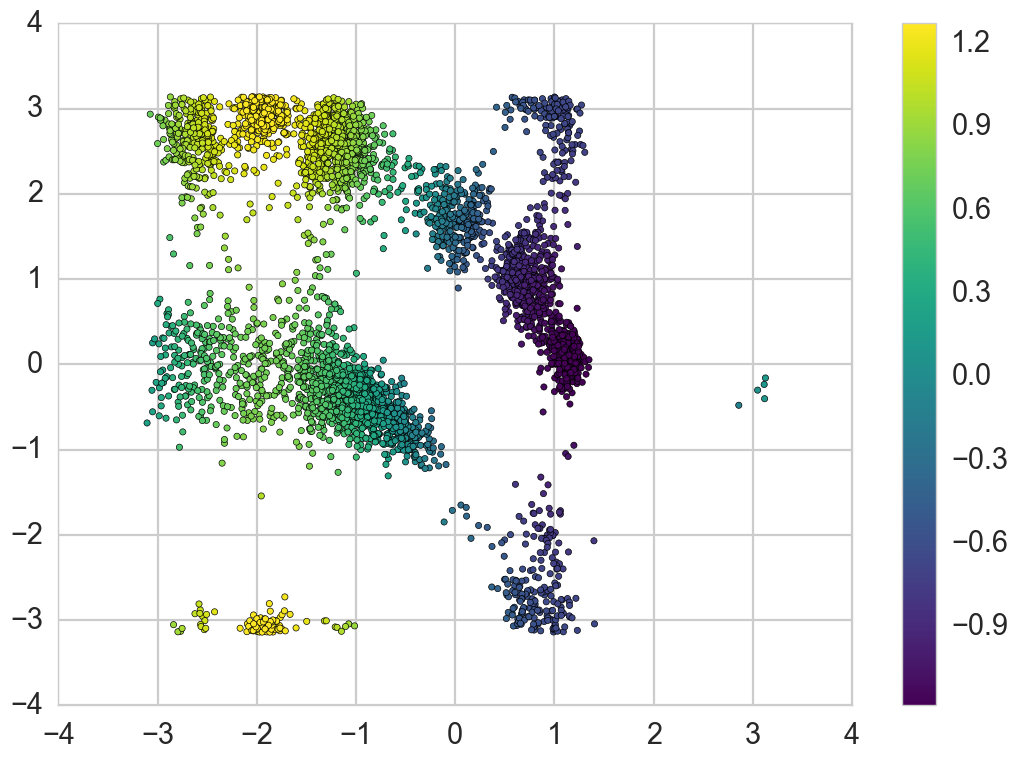

In [190]:
scatter(plot_test_feat[:,0],plot_test_feat[:,1],c=clf_out,cmap='viridis')
colorbar()

# Or re-weighting using Tiwary's time-independent estimator 

/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


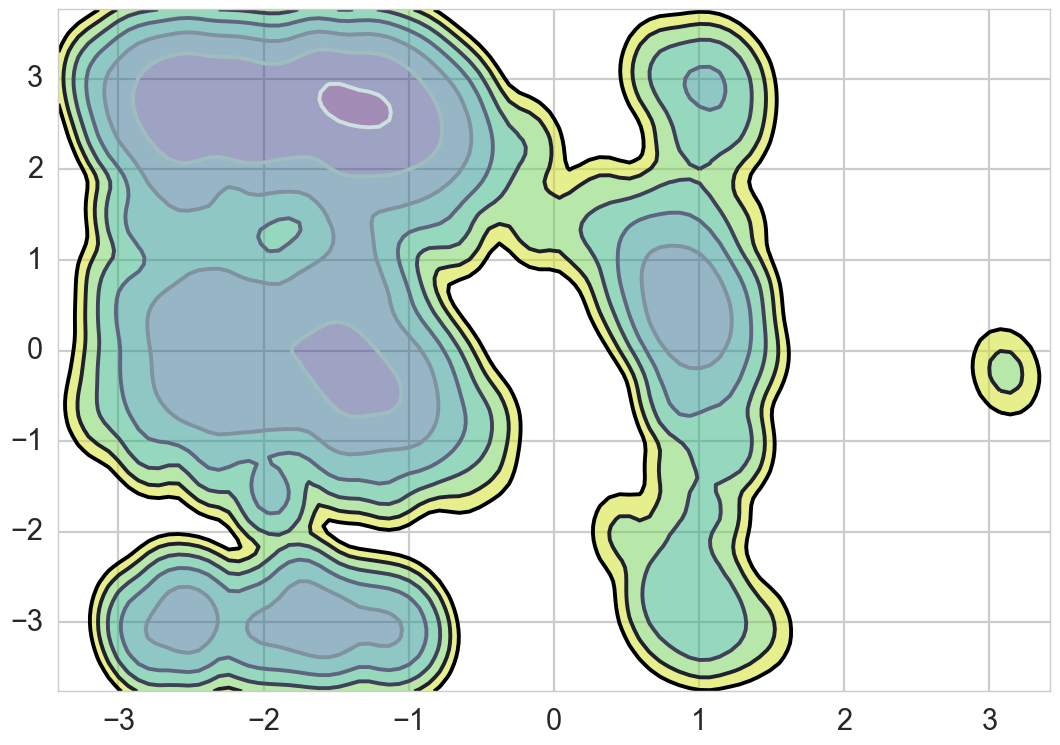

In [191]:
ax,data=msme.plot_free_energy(plot_test_feat,obs=[0,1],n_samples=100000,pi=np.exp(bias[:,-1]/2.49),
                      cmap='viridis',gridsize=100,vmin=-1,vmax=7,n_levels=8,return_data=True)

/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


(-3.141592653589793, 3.141592653589793)

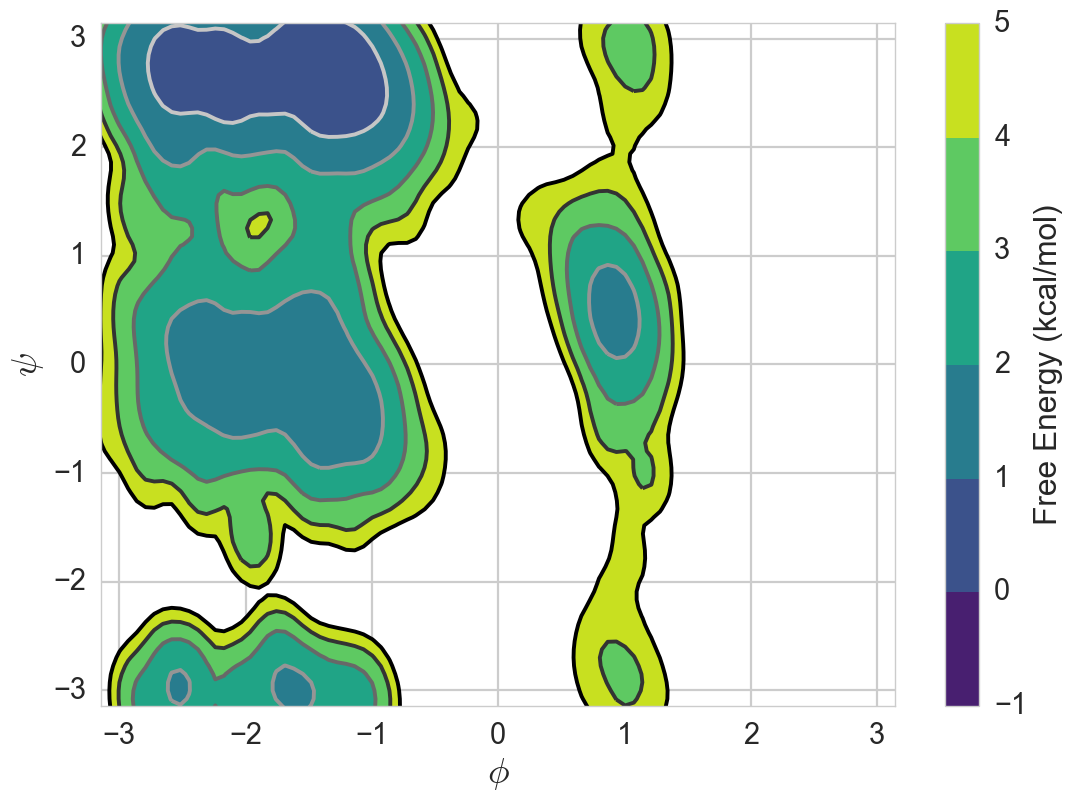

In [192]:
offset = data[2].min(0)
contour(data[0],data[1],data[2],levels=np.linspace(-1,5,7))
p=contourf(data[0],data[1],data[2],levels=np.linspace(-1,5,7),cmap='viridis')
cb=colorbar(p)
cb.set_label("Free Energy (kcal/mol)")
xlabel(r'$\phi$',size=26)
ylabel(r'$\psi$',size=26)
xlim([-pi,pi])
ylim([-pi,pi])
